# Prequisites Notebook

For the code in this notebook to work properly, the code below imports `numpy` and `matplotlib`. In addition, the numerical integration scheme for all SIR models is the 4th order Runge–Kutta (RK4), which is implemented in the same code block.

In [5]:
import handcalcs.render
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

def RK4(f, current_state: tuple, step_size: float = 0.01) -> float:
    k1 = step_size * f(*current_state)

    k2 = step_size * f(
        *[current_state[i] + k1 * 0.5 for i in range(len(current_state))]
    )
    k3 = step_size * f(
        *[current_state[i] + k2 * 0.5 for i in range(len(current_state))]
    )
    k4 = step_size * f(*[current_state[i] + k3 for i in range(len(current_state))])

    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Implementation of The Naive SIR Model




The following code defines the differential equations described above as `baseSIR` class. Variants of the SIR model using `baseSIR` class are introduced later on. 

The initial states for $S$ and $R$ are derived using the initial proportions of infectands, `I0`. For the Naive SIR model, the following assumptions are made:
1. The population is known to stay constant, $S + I + R = 1$
2. There is no initial immunity, $R(0) = 0$ 

Therefore, the initial states may be defined as follows:
1. $S(0) = 1-I(0)$
2. $R(0) = 0$

The differential equations that govern the transition from one state to another, which are implemented straightforwardly as functions `dSdt()`, `dIdt()` in `baseSIR`, are given below:

$$
\frac{dS}{dt} = -\beta S I \\
\frac{dI}{dt} = \beta S I - \gamma I \\
\frac{dR}{dt} = \gamma I
$$

However, due to the assumptions of the Naive SIR model, $\frac{dR}{dt}$ does not have to be implemented in `baseSIR`, as $S + I + R = 1$ has to hold, and therefore $R$ can be found after using the updated states of $S$ and $I$.

To find the updated values of $S$ and $I$, the 4th order Runge–Kutta (RK4) scheme is used to numerically integrate the differential equations $\frac{dS}{dt}$ and $\frac{dI}{dt}$ in `numerical_integration()`. Given the current implementation of RK4 is quick, a default step size of 0.01 is picked for accuracy. `numerical_integration()` provides an array containing the values of S, I and R over time for each step.

In [6]:
class baseSIR:
    def __init__(self, beta: float, gamma: float, I0: float):
        """
        Initialize base SIR model with model parameters and initial conditions
        """
        self.beta = beta
        self.gamma = gamma

        self.S = 1 - I0
        self.I = I0
        self.R = 0

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I

    def dIdt(self, S, I) -> float:
        """
        Differential equation for infected population.
        """
        return self.beta * S * I - self.gamma * I

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method.
        """
        self.S += RK4(self.dSdt, (self.S, self.I), step_size=dt)
        self.I += RK4(self.dIdt, (self.S, self.I), step_size=dt)
        self.R = 1 - self.S - self.I

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.arange(0, t + dt, dt)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, I_values, R_values))

To verify that `baseSIR` works accordingly, the Naive SIR model is initialized with $\beta = 3$, $\gamma = 1$ and $I(0) = 0.01$ for 30 days. `matplotlib` is used to plot curves for $S$, $I$ and $R$ seen in the graph below.

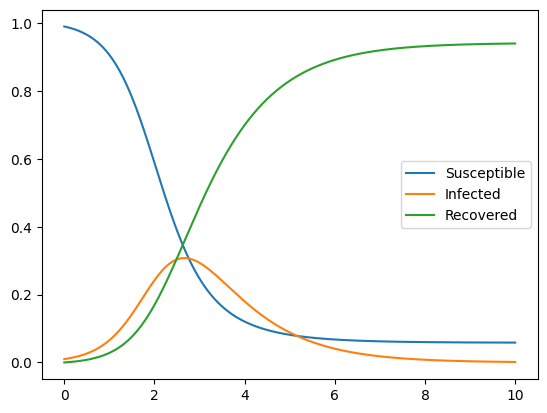

In [7]:
sir_model = baseSIR(beta=3, gamma=1, I0=0.01)
data = sir_model.numerical_integration(t=10, dt=0.01)

plt.plot(data[:, 0], data[:, 1], label='Susceptible')
plt.plot(data[:, 0], data[:, 2], label='Infected')
plt.plot(data[:, 0], data[:, 3], label='Recovered')
plt.legend()
plt.show()

In general, infectious diseases turn into epidemics when a peak in infectands is observed over time. Mathematically, this implies that, for the naive SIR model, that
1. Before the peak, the number of infectands rose, $\frac{dI}{dt} > 0$
2. Peaked, meaning that the number of infectands has attained its maximum, $\frac{dI}{dt} = 0$.
3. After the peak, the number of infectands decreases, $\frac{dI}{dt} < 0$

In order to investigate what parameters determine this chain of events, phase plots are created for different values of $\beta$, $\gamma$ and $I(0)$ through `plot_single_phase_diagram()`  

In [ ]:
def plot_single_phase_diagram(
    model_class, beta, gamma, I0_values, title=None, subplot_index=None, **model_kwargs
):
    if subplot_index is not None:
        plt.subplot(2, 3, subplot_index)
    else:
        plt.figure(figsize=(10, 8))  # Adjust size as needed

    # Plot a light red diagonal line from (1, 0) to (0, 1)
    plt.plot([1, 0], [0, 1], "r-", linewidth=1, alpha=0.7, label="Diagonal")

    # Loop through the different I0 values for the same beta, gamma pair
    for I0 in I0_values:
        model_instance = model_class(beta=beta, gamma=gamma, I0=I0, **model_kwargs)
        data = model_instance.numerical_integration(t=300, dt=0.01)
        plt.plot(
            data[:, 1], data[:, 2], color="lightblue", linewidth=1.5, alpha=0.7
        )  # Use light blue for all lines

    # Set axis limits, labels, and grid for each subplot or single plot
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Susceptible (S)")
    plt.ylabel("Infected (I)")
    plt.title(title, fontsize=10)  # Adjust font size of the subplot title
    plt.grid(True, color="gray", linestyle="--", linewidth=0.5)  # Softer grid lines
    plt.gca().set_facecolor("whitesmoke")  # Softer background color

    if subplot_index is None:
        plt.show()  # Only call show() if it's a single plot
